In [97]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import tensorflow as tf
import keras

import load_files as lf
import wrangling
import utility

import holidays

import warnings
warnings.filterwarnings('ignore')

# Manipulating Rain Prediction

In [16]:
rain_prediction = lf.get_file().load(r"D:\DC3\Full Project\rain_prediction")

In [17]:
rg_spots = \
{"Drunen":            (51.680344, 5.132245),
 "Haarsteeg":         (51.711222, 5.200918),
 "Elshout":           (51.700495, 5.142846),
 "WWTP":              (51.720422, 5.281040),
 "Bokhoven":          (51.736875, 5.233440),
 "Engelen":           (51.720494, 5.272021),
 "Maaspoort":         (51.719882, 5.290690),
 "Helftheuvelweg":    (51.700226, 5.269245),
 "Oude Engelenseweg": (51.697353, 5.290440),
 "Rompert":           (51.711202, 5.311724)}

def grid_area(rain_grid, rg: str, padding=1, reduced=False):
    
    x, y = wrangling.cell_index(rg_spots[rg][1], rg_spots[rg][0], reduced=reduced)
    
    coords = (x - padding, x + padding, y - padding, y + padding)
    
    return rain_grid[:, coords[0]:(coords[1]+1), coords[2]:(coords[3]+1)]

In [91]:
rain_grid = grid_area(rain_prediction[1], "Drunen", padding=5, reduced=True) # select 1+2*padding grid from around drunen pump

In [86]:
rain_prediction[0].head()

,pred,start,end
0,2018-01-01,2018-01-02 00:00:00,2018-01-02 01:00:00
1,2018-01-01,2018-01-02 01:00:00,2018-01-02 02:00:00
2,2018-01-01,2018-01-02 02:00:00,2018-01-02 03:00:00
3,2018-01-01,2018-01-02 03:00:00,2018-01-02 04:00:00
4,2018-01-01,2018-01-02 04:00:00,2018-01-02 05:00:00


# Manipulate Measurement Data

In [24]:
flow_data, level_data = lf.get_measurements("D:/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8150/RG8150",
                                            convert_time=True)

In [25]:
flow_data = wrangling.clean_mes_data(flow_data, convert_timestamp=False)
level_data = wrangling.clean_mes_data(level_data, convert_timestamp=False)

flow_data, level_data = wrangling.merge_flow_level(flow_data, level_data)

flow_data["Value"] = flow_data["Value"].fillna(0)
flow_data["DataQuality"] = flow_data["DataQuality"].fillna(0)

In [26]:
def flow_by_hour(df):
    flow_data = df.copy()
    
    # 
    #flow_data["TimeSpan"] = flow_data["TimeStamp"].diff(1).apply(lambda i: i.seconds).fillna(5)
    flow_data["TimeHour"] = flow_data["TimeStamp"].apply(lambda i: i.replace(minute=0, second=0))
    flow_data["Flow"] = flow_data["Value"] / 3600 * flow_data["TimeSpan"]
    
    # 
    flow_data = flow_data.groupby("TimeHour").aggregate({"Flow": np.sum, "DataQuality": np.mean})
    dt_range = pd.date_range(flow_data.index[0].floor('h'), flow_data.index[-1].floor('h'), freq='h')
    flow_data = flow_data.reindex(dt_range)
    flow_data["Flow"] = flow_data["Flow"].fillna(0)
    flow_data["DataQuality"] = flow_data["DataQuality"].fillna(0)
    
    return flow_data.reset_index(drop=False).rename(columns={"index": "TimeHour"})

In [27]:
x = flow_by_hour(flow_data)

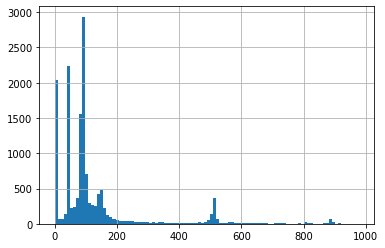

In [31]:
x.loc[x["Flow"] <= 1200, "Flow"].hist(bins=100)

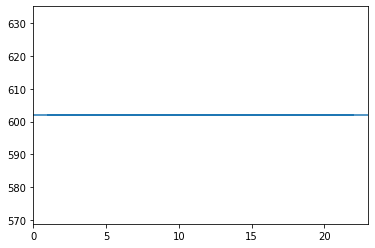

In [9]:
x["TimeHour"].apply(lambda i: i.hour).value_counts().plot()

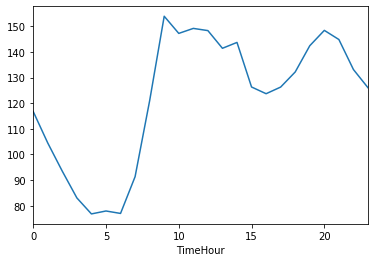

In [11]:
x["Flow"].groupby(x["TimeHour"].apply(lambda i: i.hour)).mean().plot()

In [95]:
class predictor:
    def __init__(self, data):
        NL_holidays = [i[0] for i in holidays.Netherlands(years = [2018, 2019]).items()]
        
        hour_dummies = pd.get_dummies(data["TimeHour"].apply(lambda i: i.hour), prefix="hour")
        month_dummies = pd.get_dummies(data["TimeHour"].apply(lambda i: i.month), prefix="month")
        
        is_holiday = data["TimeHour"].apply(lambda i: i.date() in NL_holidays).astype(int)
        
        self.y = data["Flow"]
        self.X = pd.concat([hour_dummies, month_dummies, is_holiday], axis=1)
        self.X["Constant"] = 1

In [68]:
shared_indices = np.intersect1d(rain_prediction[0]["start"].values, x["TimeHour"].values)
rp_indices = rain_prediction[0]["start"].reset_index(drop=False).set_index("start").reindex(shared_indices).values.flatten()

In [92]:
y = x.set_index("TimeHour").reindex(shared_indices)["Flow"].values

In [103]:
#X = rain_prediction[1][rp_indices]
X_grid = rain_grid[rp_indices]

In [108]:
X_grid = X_grid.reshape(X_grid.shape[0], X_grid.shape[1] * X_grid.shape[2])

In [109]:
df = x.set_index("TimeHour").reindex(shared_indices).reset_index(drop=False)
X = predictor(df).X.values

In [118]:
X = np.concatenate((X_grid, X), axis=1)

In [125]:
X.shape

(14424, 159)

# Model

In [120]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, GlobalMaxPooling2D, Conv1D, Input, GlobalAveragePooling1D, Lambda
from keras.layers import Bidirectional, AveragePooling1D, GaussianNoise, Concatenate, SeparableConv2D
from keras.layers import concatenate, MaxPooling2D, AveragePooling2D, GlobalAveragePooling3D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras import regularizers
from sklearn.cluster import AgglomerativeClustering, DBSCAN, MeanShift, KMeans
from keras.layers import DepthwiseConv2D
from keras import optimizers
from keras.layers import Layer, Reshape
import keras.backend as K
from keras.constraints import maxnorm, nonneg

In [132]:
X.shape

(14424, 159)

In [175]:
#input_1 = Input(shape = (X.shape[1], X.shape[2]))
input_1 = Input(shape = (None, X.shape[1]))

# Multiply all values by smth
#out = Flatten()(input_1)
#out = ConstMultiplierLayer()(out)
#out = Reshape(target_shape=(X.shape[1], X.shape[2], 1))(out)

# TAKE AVG OF ALL VALUES 
#out = SumLayer()(out)
out = Dense(1)(input_1)

model = Model(input_1, out)
model.compile(optimizer = optimizers.Adam(lr=0.001), loss='mean_squared_error')

for i in model.layers:
    print(i.output_shape)

(None, None, 159)
(None, None, 1)


In [192]:
model = Sequential()
model.add(Dense(10, input_dim=159, activation="relu"))
model.add(Dense(1))

model.compile(optimizer = optimizers.Adam(lr=0.01), loss='mean_squared_error')

for i in model.layers:
    print(i.output_shape)

(None, 10)
(None, 1)


In [193]:
model.fit(X, y, validation_split=0.1, epochs=150, batch_size=512, shuffle=True)

Train on 12981 samples, validate on 1443 samples
Epoch 1/150
12981/12981 [==============================] - 1s 67us/step - loss: 164861.5529 - val_loss: 36734.9118
Epoch 2/150
12981/12981 [==============================] - 0s 16us/step - loss: 50736.6824 - val_loss: 35220.0799
Epoch 3/150
12981/12981 [==============================] - 0s 9us/step - loss: 48393.5930 - val_loss: 33931.1184
Epoch 4/150
12981/12981 [==============================] - 0s 13us/step - loss: 47034.3124 - val_loss: 33302.6729
Epoch 5/150
12981/12981 [==============================] - 0s 15us/step - loss: 46191.8705 - val_loss: 32697.5399
Epoch 6/150
12981/12981 [==============================] - 0s 8us/step - loss: 45498.5634 - val_loss: 32089.2605
Epoch 7/150
12981/12981 [==============================] - 0s 7us/step - loss: 44762.9589 - val_loss: 31455.5798
Epoch 8/150
12981/12981 [==============================] - 0s 7us/step - loss: 43989.3968 - val_loss: 30776.2003
Epoch 9/150
12981/12981 [=================

12981/12981 [==============================] - 0s 12us/step - loss: 34648.3504 - val_loss: 23580.3785
Epoch 73/150
12981/12981 [==============================] - 0s 11us/step - loss: 34637.0032 - val_loss: 23600.7720
Epoch 74/150
12981/12981 [==============================] - 0s 7us/step - loss: 34613.2496 - val_loss: 23551.9251
Epoch 75/150
12981/12981 [==============================] - 0s 13us/step - loss: 34603.2372 - val_loss: 23535.0682
Epoch 76/150
12981/12981 [==============================] - 0s 10us/step - loss: 34584.6112 - val_loss: 23504.9718
Epoch 77/150
12981/12981 [==============================] - 0s 6us/step - loss: 34561.1518 - val_loss: 23610.1303
Epoch 78/150
12981/12981 [==============================] - 0s 8us/step - loss: 34555.8271 - val_loss: 23567.1369
Epoch 79/150
12981/12981 [==============================] - 0s 10us/step - loss: 34551.6934 - val_loss: 23499.7878
Epoch 80/150
12981/12981 [==============================] - 0s 10us/step - loss: 34531.2039 - va

12981/12981 [==============================] - 0s 15us/step - loss: 33718.6894 - val_loss: 23226.3311
Epoch 144/150
12981/12981 [==============================] - 0s 6us/step - loss: 33719.1576 - val_loss: 23308.6417
Epoch 145/150
12981/12981 [==============================] - 0s 14us/step - loss: 33713.1343 - val_loss: 23307.4297
Epoch 146/150
12981/12981 [==============================] - 0s 16us/step - loss: 33727.3017 - val_loss: 23340.5558
Epoch 147/150
12981/12981 [==============================] - 0s 8us/step - loss: 33715.7898 - val_loss: 23319.9002
Epoch 148/150
12981/12981 [==============================] - 0s 12us/step - loss: 33709.7553 - val_loss: 23240.3245
Epoch 149/150
12981/12981 [==============================] - 0s 20us/step - loss: 33701.4516 - val_loss: 23304.5394
Epoch 150/150
12981/12981 [==============================] - 0s 8us/step - loss: 33702.3477 - val_loss: 23365.4451


In [187]:
weights = model.layers[0].get_weights()[0].flatten()[0:121].reshape(11,11)

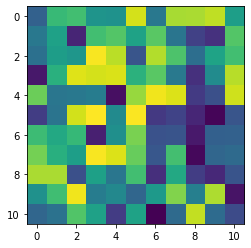

In [189]:
plt.imshow(weights) # 11x11 grid around Drunen -- parameters from model visualized, no pattern

In [184]:
weights = model.layers[0].get_weights()[0].flatten()[(121+0):(121+24)]#.reshape(11,11)

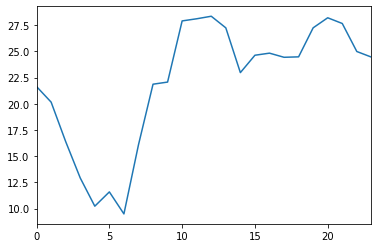

In [185]:
pd.Series(weights).plot() # Time of the day parameters visualized

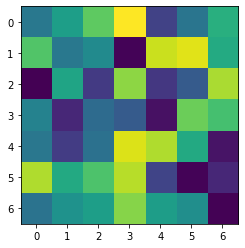

In [66]:
plt.imshow(model.layers[2].get_weights()[0].flatten().reshape((7,7))) # 7x7 grid around Drunen -- parameters from model visualized, no pattern

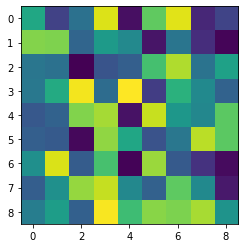

In [73]:
plt.imshow(model.layers[2].get_weights()[0].flatten().reshape((9,9))) # 9x9 grid around Drunen -- parameters from model visualized, no pattern

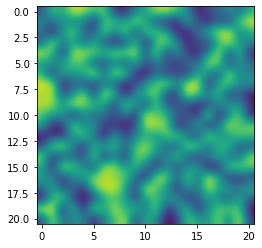

In [90]:
weights = model.layers[2].get_weights()[0].flatten().reshape((21,21)) # 21x21 grid around Drunen -- parameters from model visualized, no pattern

plt.imshow(weights, interpolation="bicubic")

In [36]:
class ConstMultiplierLayer(Layer):
    def __init__(self, **kwargs):
        super(ConstMultiplierLayer, self).__init__(**kwargs)

    def build(self, input_shape, regularizer=None):
        self.k = self.add_weight(
            name='k',
            shape=(input_shape[1],),
            regularizer=regularizer,
            initializer='zeros',
            dtype='float32',
            trainable=True,
            constraint=nonneg()
        )
        super(ConstMultiplierLayer, self).build(input_shape)

    def call(self, x):
        return K.tf.multiply(self.k, x)

    def compute_output_shape(self, input_shape):
        return input_shape

    
class AvgLayer(Layer):
    def __init__(self, **kwargs):
        super(AvgLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(AvgLayer, self).build(input_shape)

    def call(self, x):
        return K.mean(x)

    def compute_output_shape(self, input_shape):
        return (None,1)
    

class SumLayer(Layer):
    def __init__(self, **kwargs):
        super(SumLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SumLayer, self).build(input_shape)

    def call(self, x):
        return K.sum(x)

    def compute_output_shape(self, input_shape):
        return (None,1)


def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [38]:
input_1 = Input(shape = (X.shape[1], X.shape[2]))

#out = Conv1D(32, kernel_size=5, strides=2)(input_1)

# Multiply all values by smth
out = Flatten()(input_1)
out = ConstMultiplierLayer()(out)
out = Reshape(target_shape=(X.shape[1], X.shape[2], 1))(out)

# Gaussian Smoothing
kernel_size = 5
in_channels = 1  # the number of input channels
kernel_weights = matlab_style_gauss2D(shape=(kernel_size, kernel_size), sigma = 0.5)
kernel_weights = np.expand_dims(kernel_weights, axis=-1)
kernel_weights = np.repeat(kernel_weights, in_channels, axis=-1) # apply the same filter on all the input channels
kernel_weights = np.expand_dims(kernel_weights, axis=-1)

#print(kernel_weights)

out = Conv2D(filters = 1, kernel_size=(kernel_size, kernel_size), use_bias=False, padding="same")(out)

out = Flatten()(out)

# TAKE AVG OF ALL VALUES 
out = SumLayer()(out)




model = Model(input_1, out)

model.layers[4].set_weights([kernel_weights])
model.layers[4].trainable = False

model.compile(optimizer = optimizers.Adam(lr=0.001), loss='mean_squared_error')

for i in model.layers:
    print(i.output_shape)




(None, 7, 7)
(None, 49)
(None, 49)
(None, 7, 7, 1)
(None, 7, 7, 1)
(None, 49)
(None, 1)


In [222]:
model.fit(X, y, validation_split=0.1, epochs=5, batch_size=1024, shuffle=True)

Train on 13089 samples, validate on 1455 samples
Epoch 1/5
13089/13089 [==============================] - 67s 5ms/step - loss: 1307280464.7273 - val_loss: 37127.5742
Epoch 2/5
13089/13089 [==============================] - 63s 5ms/step - loss: 48663712.7686 - val_loss: 41860.7620
Epoch 3/5
13089/13089 [==============================] - 61s 5ms/step - loss: 13367637.8162 - val_loss: 40157.3815
Epoch 4/5
13089/13089 [==============================] - 58s 4ms/step - loss: 37173829.0081 - val_loss: 38055.0913
Epoch 5/5
13089/13089 [==============================] - 58s 4ms/step - loss: 27758002.5219 - val_loss: 40117.3126


In [223]:
weights = model.layers[2].get_weights()[0].flatten().reshape(X.shape[1], X.shape[2])

(-0.5, 122.5, 104.5, -0.5)

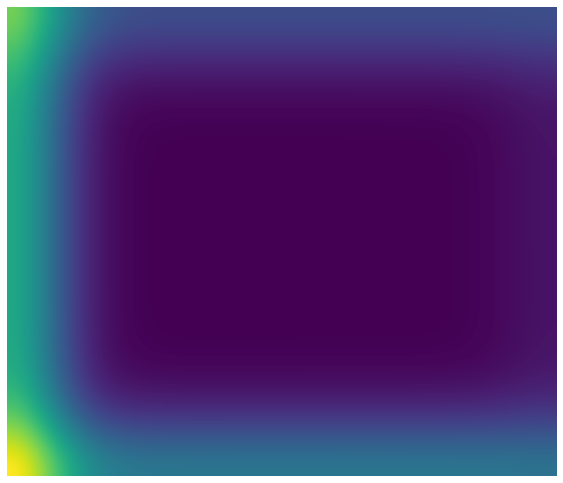

In [224]:
fig, ax = plt.subplots(figsize = (6.56 * 1.5, 10.15 * 1.5))

ax.imshow(scipy.ndimage.filters.gaussian_filter(weights, sigma=10), interpolation="bicubic")   # Interpolation anti-aliases the image
plt.axis('off')